In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from HW2.benchmark_proceeder import BenchmarkStorage
from HW2.regression_generator import generate_regression
from HW2.sgd import sgd, minibatch_gd, gd
from HW2.visualization import visualize_regression_point, visualize_line, draw_levels
from HW2.optimization import *

[ -7.20170139 -23.14774303]


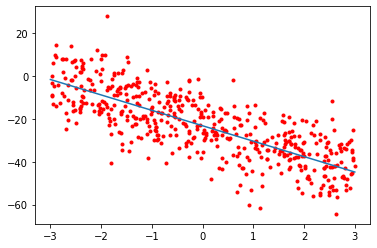

In [2]:
f, points, f_ab = generate_regression(f_scale=50, point_count=500, scale=np.array([3, 10]))

print(f_ab)

visualize_regression_point(f, points, scale=3)

storage = BenchmarkStorage()

# No optimizations

[ -6.66614049 -20.46785893]
Benchmark results for config <('sgd', 1, Default(no) optimization, Squared error calculator)>:
Mean time:0.109567
Mean memory:0.0B
Mean SMAPE value:0.2812289372239691
Mean RMSE value:10.384870115008917
Mean logcosh value:7.73230476744081
Mean gradient calls:675.0
Iterations done:675.0


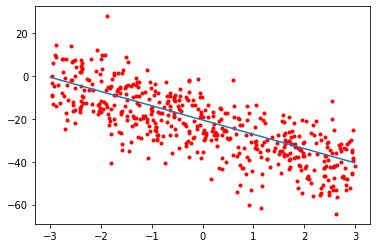

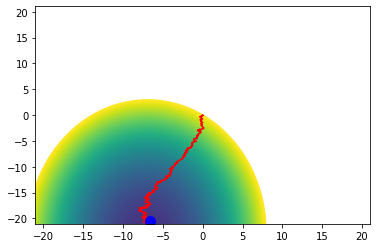

In [3]:
index = storage.add_benchmark_config()
ab, meta = sgd(points)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[ -7.15654858 -20.81883416]
Benchmark results for config <('mini50', 1, Default(no) optimization, Squared error calculator)>:
Mean time:1.481332
Mean memory:0.0B
Mean SMAPE value:0.28648167992125995
Mean RMSE value:10.292105347368745
Mean logcosh value:7.653970873506918
Mean gradient calls:32150.0
Iterations done:643.0


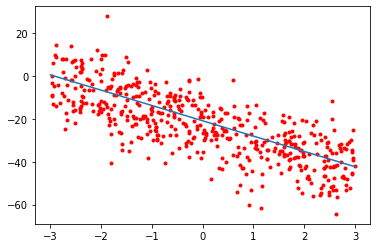

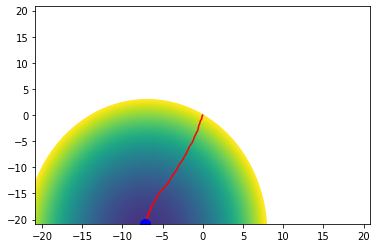

In [4]:
index = storage.add_benchmark_config(batch_size='mini50')
ab, meta = minibatch_gd(points, batch_size=50)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

# Momentum optimization

[ -7.20593905 -20.34902356]
Benchmark results for config <('sgd', 1, Momentum optimization (beta=0.95), Squared error calculator)>:
Mean time:0.128336
Mean memory:0.0B
Mean SMAPE value:0.29226322014229095
Mean RMSE value:10.400099328642876
Mean logcosh value:7.72916719996938
Mean gradient calls:568.0
Iterations done:568.0


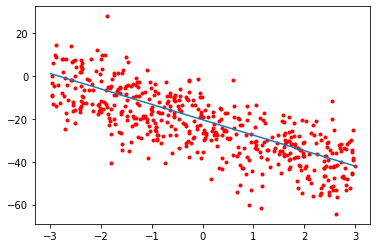

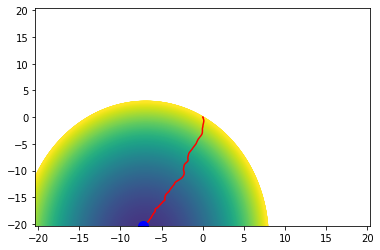

In [5]:
optimization = MomentumOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[ -7.35928129 -20.95305265]
Benchmark results for config <('mini50', 1, Momentum optimization (beta=0.95), Squared error calculator)>:
Mean time:1.373658
Mean memory:0.0B
Mean SMAPE value:0.2886805252343396
Mean RMSE value:10.27933483519419
Mean logcosh value:7.640639898280425
Mean gradient calls:32950.0
Iterations done:659.0


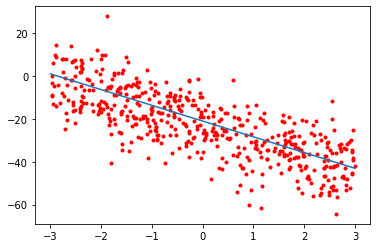

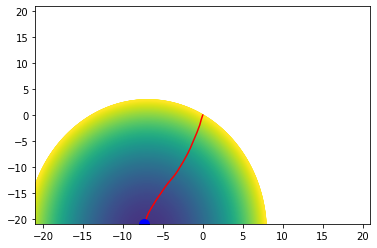

In [6]:
optimization = MomentumOptimization(beta=0.95)
index = storage.add_benchmark_config(batch_size='mini50', optimiser=optimization)
ab, meta = minibatch_gd(points, optimization=optimization, batch_size=50)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Учитываем не градиент, а его скользящее среднее
* Грубо говоря сохраняется "ускорение" градиента по каждой из координат
* Из-за этого график получается более гладким

# Nesterov optimization

[ -6.14308922 -23.38487959]
Benchmark results for config <('sgd', 1, Nesterov optimization (beta=0.95), Squared error calculator)>:
Mean time:0.157251
Mean memory:0.0B
Mean SMAPE value:0.2529368030813111
Mean RMSE value:10.203107403077317
Mean logcosh value:7.5499285077746645
Mean gradient calls:790.0
Iterations done:790.0


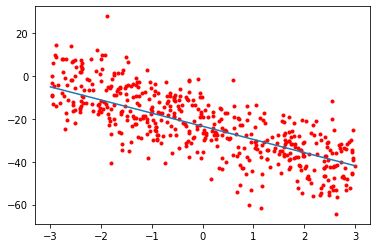

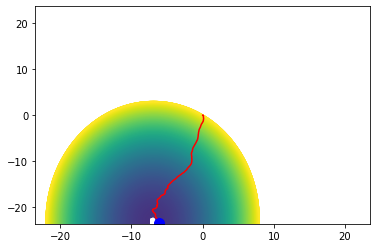

In [7]:
optimization = NesterovOptimization(beta=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[ -6.99205976 -21.58711002]
Benchmark results for config <('mini50', 1, Nesterov optimization (beta=0.95), Squared error calculator)>:
Mean time:1.407217
Mean memory:0.0B
Mean SMAPE value:0.2749453816083871
Mean RMSE value:10.161475808849003
Mean logcosh value:7.560919654882283
Mean gradient calls:32800.0
Iterations done:656.0


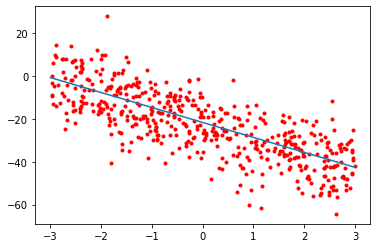

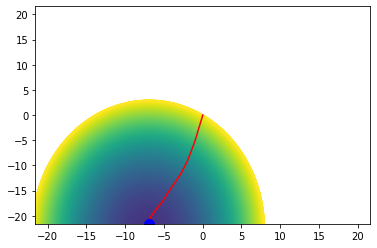

In [9]:
optimization = NesterovOptimization(beta=0.95)
index = storage.add_benchmark_config(batch_size='mini50', optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* Как и в `Momentum`, считаем градиент, а его скользящее среднее
* Но берем градиент уже из точки, сдвинутой на скользящее среднее
* По сравнению с `Momentum` это просто его оптимизация, которая в некоторых случаях модет помочь
* Но в общем случае разницы практически нет

# AdaGrad optimization

[ -3.41932765 -11.97226861]
Benchmark results for config <('sgd', 1, Ada gradient optimization (eps=1e-05), Squared error calculator)>:
Mean time:1.244403
Mean memory:0.0B
Mean SMAPE value:0.39382613890619717
Mean RMSE value:16.091876644012334
Mean logcosh value:12.499503313153047
Mean gradient calls:6649.0
Iterations done:6649.0


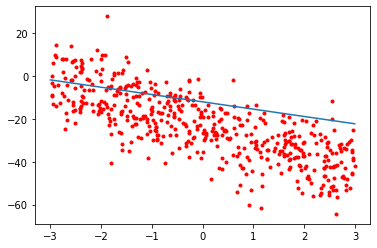

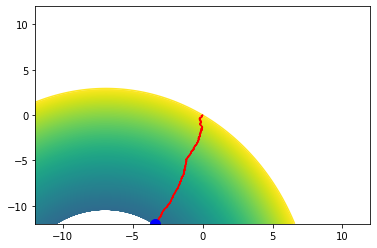

In [14]:
optimization = AdaGradOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization, eps=5e-3)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
index = storage.add_benchmark_config(optimiser=optimization)
draw_levels(points, meta["points"])

[ -3.23087388 -11.59699754]
Benchmark results for config <('mini50', 1, Ada gradient optimization (eps=1e-05), Squared error calculator)>:
Mean time:1.170295
Mean memory:0.0B
Mean SMAPE value:0.4022882869934838
Mean RMSE value:16.473129314859886
Mean logcosh value:12.836603356298601
Mean gradient calls:6289.0
Iterations done:6289.0


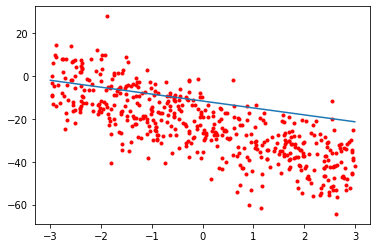

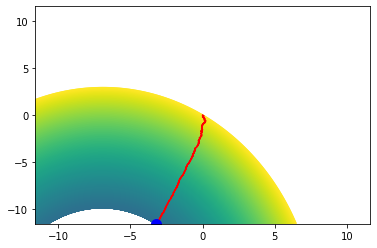

In [15]:
optimization = AdaGradOptimization()
index = storage.add_benchmark_config(batch_size='mini50', optimiser=optimization)
ab, meta = minibatch_gd(points, optimization=optimization, eps=5e-3)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
index = storage.add_benchmark_config(optimiser=optimization)
draw_levels(points, meta["points"])

#### Наблюдения

* В `AdaGrad` мы накапливаем сумму квадратов градиентов и делим `lr` на нее
* С одной стороны это помогает под каждую из координат градиента по разному применять `lr` (например, если она убывает очень резко, а другая -- нет, то мы из "синхронизируем")
* Но также это чревато `lr decay`, что в свою очередь требует больше шагов для достижения $\pm$ того же результата, что и с предыдущими оптимизаторам

# RMSProp optimization

[ -5.40885773 -16.45960285]
Benchmark results for config <('sgd', 1, RMS prop optimization (gamma=0.95, eps=1e-05), Squared error calculator)>:
Mean time:0.495165
Mean memory:0.0B
Mean SMAPE value:0.3187358700087769
Mean RMSE value:12.275492468498134
Mean logcosh value:9.190416337308362
Mean gradient calls:2514.0
Iterations done:2514.0


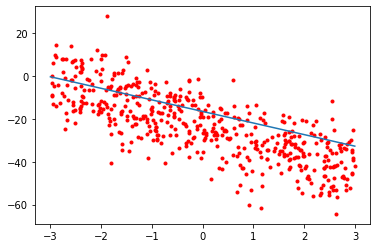

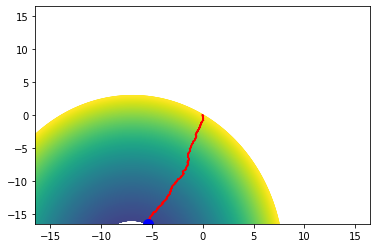

In [22]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization, lr=0.01, eps=2e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[ -7.04646474 -22.88468984]
Benchmark results for config <('mini50', 1, RMS prop optimization (gamma=0.95, eps=1e-05), Squared error calculator)>:
Mean time:4.80269
Mean memory:0.0B
Mean SMAPE value:0.2643826667007321
Mean RMSE value:10.07478699855595
Mean logcosh value:7.490020355681203
Mean gradient calls:132500.0
Iterations done:2650.0


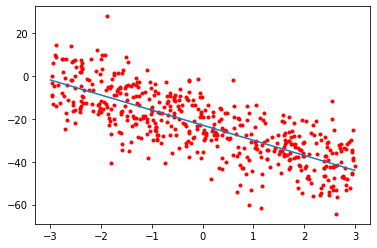

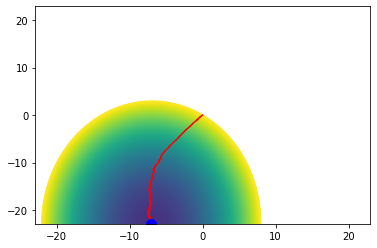

In [23]:
optimization = RMSPropOptimization(gamma=0.95)
index = storage.add_benchmark_config(batch_size='mini50', optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization, lr=0.01, eps=2e-2)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* По сравнению с `AdaGrad`, здесь мы считаем скользящее среднее квадратов градиентов, вместо суммы
* Это позволяет график убывания `lr` сделать более гладким
* Что в свою очередь ведет к более быстрому схождению, по сравнению с `AdaGrad`

# Adam optimization

[ -6.75705083 -22.6608427 ]
Benchmark results for config <('sgd', 1, Adam optimization (beta_1=0.9, beta_2=0.999, eps=1e-05), Squared error calculator)>:
Mean time:0.204974
Mean memory:0.0B
Mean SMAPE value:0.26171940796189674
Mean RMSE value:10.089089289667948
Mean logcosh value:7.499666970008397
Mean gradient calls:1158.0
Iterations done:1158.0


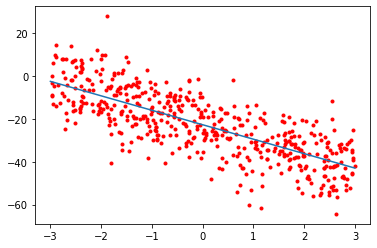

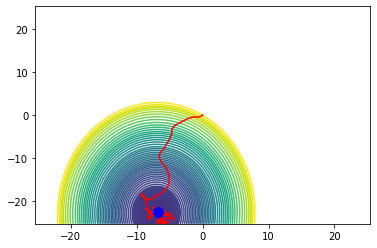

In [24]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = sgd(points, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

[ -7.09262461 -23.03160054]
Benchmark results for config <('sgd', 1, Adam optimization (beta_1=0.9, beta_2=0.999, eps=1e-05), Squared error calculator)>:
Mean time:1.356239
Mean memory:0.0B
Mean SMAPE value:0.2641146178832807
Mean RMSE value:10.075949649511571
Mean logcosh value:7.490183181142593
Mean gradient calls:34000.0
Iterations done:680.0


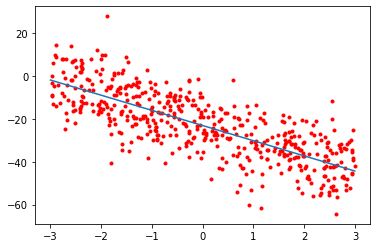

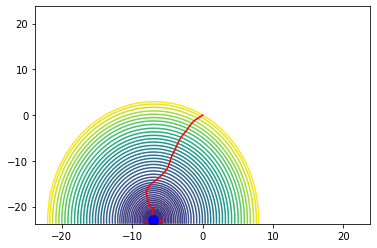

In [25]:
optimization = AdamOptimization()
index = storage.add_benchmark_config(optimiser=optimization)
ab, meta = minibatch_gd(points, batch_size=50, optimization=optimization)
storage.add_benchmark_result(index, meta)

print(ab)
print(storage.get_benchmark_results(index))

visualize_line(ab, points)
draw_levels(points, meta["points"])

#### Наблюдения

* `Adam` включает в себя все вышеупомянутые идеи
* Считается скользящие средние по градиенту и его квадрату
* Это позволяет сделать сам график сходимости гладким
* Также каждая из координат градиента учитывается в релаксиции координат по-своему
* Все это ведет к быстрому и более точному схождению

# Benchmark

In [26]:
optimizators = [DefaultOptimization(), MomentumOptimization(0.95), NesterovOptimization(0.95), AdaGradOptimization(),
                RMSPropOptimization(0.5), AdamOptimization()]

result = np.array([])
for optimization in tqdm(optimizators, "Optimization"):
    index = storage.add_benchmark_config(optimiser=optimization)
    for _ in range(20):
        ab, meta = minibatch_gd(points, optimization=optimization)
        storage.add_benchmark_result(index, meta)
    result = np.append(result, storage.get_benchmark_results_arrayed(index))

result = result.reshape((-1, 8))
df = pd.DataFrame(result, columns=[
    'Config',
    'Mean time',
    'Mean mem',
    'Mean SMAPE',
    'Mean RMSE',
    'Mean logcosh',
    'Mean gradient calls',
    'Mean iterations'
])
df.to_csv("data/2.3.csv", sep='\t')
df

Optimization:   0%|          | 0/6 [00:00<?, ?it/s]

,Config,Mean time,Mean mem,Mean SMAPE,Mean RMSE,Mean logcosh,Mean gradient calls,Mean iterations
0,"(sgd, 1, Default(no) optimization, Squared err...",0.263228,0.0B,0.265945,10.131355,7.52414,1727.9,1727.9
1,"(sgd, 1, Momentum optimization (beta=0.95), Sq...",0.113763,0.0B,0.281195,10.376857,7.713593,664.65,664.65
2,"(sgd, 1, Nesterov optimization (beta=0.95), Sq...",0.100617,0.0B,0.27568,10.314318,7.670791,652.65,652.65
3,"(sgd, 1, Ada gradient optimization (eps=1e-05)...",0.006209,0.0B,0.970935,27.475242,22.860517,51.6,51.6
4,"(sgd, 1, RMS prop optimization (gamma=0.5, eps...",1.770709,0.0B,0.26776,10.131398,7.533091,10000.0,10000.0
5,"(sgd, 1, Adam optimization (beta_1=0.9, beta_2...",0.137856,0.0B,0.269599,10.224028,7.590115,753.15,753.15
